Code for **"Activation maximization"** figure.

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

You can select net type (`vgg_16_caffe`, `vgg19_caffe`, `alexnet`) and a layer. For your reference the layer names for each network type are shown below.

In [2]:
vgg_19_names=['conv1_1','relu1_1','conv1_2','relu1_2','pool1',
              'conv2_1','relu2_1','conv2_2','relu2_2','pool2',
              'conv3_1','relu3_1','conv3_2','relu3_2','conv3_3','relu3_3','conv3_4','relu3_4','pool3',
              'conv4_1','relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','conv4_4','relu4_4','pool4',
              'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','conv5_4','relu5_4','pool5',
              'torch_view','fc6','relu6','drop6','fc7','relu7','drop7','fc8']

vgg_16_names = ['conv1_1','relu1_1','conv1_2','relu1_2','pool1',
                'conv2_1','relu2_1','conv2_2','relu2_2','pool2',
                'conv3_1','relu3_1','conv3_2','relu3_2','conv3_3','relu3_3','pool3',
                'conv4_1','relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','pool4',
                'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','pool5',
                'torch_view','fc6','relu6','drop6','fc7','relu7','fc8']

alexnet_names = ['conv1', 'relu1', 'norm1', 'pool1',
                 'conv2', 'relu2', 'norm2', 'pool2',
                 'conv3', 'relu3', 'conv4', 'relu4',
                 'conv5', 'relu5', 'pool5', 'torch_view',
                 'fc6', 'relu6', 'drop6',
                 'fc7', 'relu7', 'drop7',
                 'fc8', 'softmax']

The actual code starts here.

# Import libs

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from utils.perceptual_loss.perceptual_loss import *
from utils.common_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
fname = './data/feature_inversion/building.jpg'

# Choose net type
pretrained_net = 'alexnet_caffe' 
assert pretrained_net in ['alexnet_caffe', 'vgg19_caffe', 'vgg16_caffe']

# Choose layers
layer_to_use = 'conv4'

In [4]:
import json
with open('data/imagenet1000_clsid_to_human.txt', 'r') as f:
    corresp = json.load(f)
    

if layer_to_use == 'fc8':
    # Choose class
    name = 'black swan'
    # name = 'cheeseburger'

    map_idx = None
    for k,v in corresp.items():
        if name in v:
            map_idx = int(k)
            break
else:
    map_idx = 2 # Choose here

# Setup pretrained net

In [5]:
# Target imsize 
imsize = 227 if pretrained_net == 'alexnet_caffe' else 224

# Something divisible by a power of two
imsize_net = 256

# VGG and Alexnet need input to be correctly normalized
preprocess, deprocess = get_preprocessor(imsize), get_deprocessor()


img_content_pil, img_content_np  = get_image(fname, -1)
img_content_prerocessed = preprocess(img_content_pil)[None,:].type(dtype)

In [6]:
opt_content = {'layers': [layer_to_use], 'what':'features', 'map_idx': map_idx}

cnn = get_pretrained_net(pretrained_net).type(dtype)
cnn.add_module('softmax', nn.Softmax())

# Remove the layers we don't need 
keys = [x for x in cnn._modules.keys()]
max_idx = max(keys.index(x) for x in opt_content['layers'])
for k in keys[max_idx+1:]:
    cnn._modules.pop(k)
    
print(cnn)

--2021-12-23 17:01:00--  https://box.skoltech.ru/index.php/s/77xSWvrDN0CiQtK/download
Resolving box.skoltech.ru (box.skoltech.ru)... 195.133.216.199
Connecting to box.skoltech.ru (box.skoltech.ru)|195.133.216.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243884055 (233M) [application/octet-stream]
Saving to: ‘alexnet-torch_py3.pth’

     0K .......... .......... .......... .......... ..........  0%  175K 22m37s
    50K .......... .......... .......... .......... ..........  0%  356K 16m53s
   100K .......... .......... .......... .......... ..........  0% 23.2M 11m18s
   150K .......... .......... .......... .......... ..........  0% 21.5M 8m31s
   200K .......... .......... .......... .......... ..........  0%  357K 9m2s
   250K .......... .......... .......... .......... ..........  0% 23.6M 7m33s
   300K .......... .......... .......... .......... ..........  0% 23.2M 6m30s
   350K .......... .......... .......... .......... ..........  0% 22.2M 5m42s

  6050K .......... .......... .......... .......... ..........  2% 50.5M 50s
  6100K .......... .......... .......... .......... ..........  2% 50.7M 50s
  6150K .......... .......... .......... .......... ..........  2% 39.0M 50s
  6200K .......... .......... .......... .......... ..........  2% 43.0M 49s
  6250K .......... .......... .......... .......... ..........  2% 46.6M 49s
  6300K .......... .......... .......... .......... ..........  2% 46.4M 48s
  6350K .......... .......... .......... .......... ..........  2% 2.61M 49s
  6400K .......... .......... .......... .......... ..........  2% 16.5M 48s
  6450K .......... .......... .......... .......... ..........  2% 37.9M 48s
  6500K .......... .......... .......... .......... ..........  2% 38.3M 48s
  6550K .......... .......... .......... .......... ..........  2% 41.2M 47s
  6600K .......... .......... .......... .......... ..........  2% 33.3M 47s
  6650K .......... .......... .......... .......... ..........  2% 37.9M 47s

 11850K .......... .......... .......... .......... ..........  4% 35.9M 34s
 11900K .......... .......... .......... .......... ..........  5% 37.5M 34s
 11950K .......... .......... .......... .......... ..........  5% 30.9M 34s
 12000K .......... .......... .......... .......... ..........  5% 29.8M 33s
 12050K .......... .......... .......... .......... ..........  5% 31.8M 33s
 12100K .......... .......... .......... .......... ..........  5% 26.3M 33s
 12150K .......... .......... .......... .......... ..........  5% 28.7M 33s
 12200K .......... .......... .......... .......... ..........  5% 26.2M 33s
 12250K .......... .......... .......... .......... ..........  5% 33.3M 33s
 12300K .......... .......... .......... .......... ..........  5% 35.6M 33s
 12350K .......... .......... .......... .......... ..........  5% 36.5M 33s
 12400K .......... .......... .......... .......... ..........  5% 40.3M 32s
 12450K .......... .......... .......... .......... ..........  5% 45.5M 32s

 19000K .......... .......... .......... .......... ..........  7% 4.04M 26s
 19050K .......... .......... .......... .......... ..........  8% 29.0M 26s
 19100K .......... .......... .......... .......... ..........  8% 28.7M 26s
 19150K .......... .......... .......... .......... ..........  8% 28.2M 25s
 19200K .......... .......... .......... .......... ..........  8% 21.1M 25s
 19250K .......... .......... .......... .......... ..........  8% 27.8M 25s
 19300K .......... .......... .......... .......... ..........  8% 27.7M 25s
 19350K .......... .......... .......... .......... ..........  8% 24.6M 25s
 19400K .......... .......... .......... .......... ..........  8% 17.0M 25s
 19450K .......... .......... .......... .......... ..........  8% 26.7M 25s
 19500K .......... .......... .......... .......... ..........  8% 36.7M 25s
 19550K .......... .......... .......... .......... ..........  8% 44.2M 25s
 19600K .......... .......... .......... .......... ..........  8% 38.2M 25s

 25550K .......... .......... .......... .......... .......... 10%  511K 23s
 25600K .......... .......... .......... .......... .......... 10% 32.8M 23s
 25650K .......... .......... .......... .......... .......... 10% 34.3M 23s
 25700K .......... .......... .......... .......... .......... 10% 33.5M 23s
 25750K .......... .......... .......... .......... .......... 10% 40.0M 23s
 25800K .......... .......... .......... .......... .......... 10% 43.0M 23s
 25850K .......... .......... .......... .......... .......... 10% 46.0M 23s
 25900K .......... .......... .......... .......... .......... 10% 56.5M 23s
 25950K .......... .......... .......... .......... .......... 10% 1.63M 23s
 26000K .......... .......... .......... .......... .......... 10% 24.0M 23s
 26050K .......... .......... .......... .......... .......... 10% 27.2M 23s
 26100K .......... .......... .......... .......... .......... 10% 30.5M 23s
 26150K .......... .......... .......... .......... .......... 11% 35.9M 23s

 31350K .......... .......... .......... .......... .......... 13% 48.6M 21s
 31400K .......... .......... .......... .......... .......... 13%  548K 21s
 31450K .......... .......... .......... .......... .......... 13% 35.4M 21s
 31500K .......... .......... .......... .......... .......... 13% 45.0M 21s
 31550K .......... .......... .......... .......... .......... 13% 37.8M 21s
 31600K .......... .......... .......... .......... .......... 13% 29.0M 21s
 31650K .......... .......... .......... .......... .......... 13% 33.5M 21s
 31700K .......... .......... .......... .......... .......... 13% 37.6M 21s
 31750K .......... .......... .......... .......... .......... 13% 30.6M 21s
 31800K .......... .......... .......... .......... .......... 13% 33.5M 21s
 31850K .......... .......... .......... .......... .......... 13% 32.3M 21s
 31900K .......... .......... .......... .......... .......... 13% 32.0M 21s
 31950K .......... .......... .......... .......... .......... 13% 36.0M 21s

 37850K .......... .......... .......... .......... .......... 15%  542K 20s
 37900K .......... .......... .......... .......... .......... 15% 29.7M 20s
 37950K .......... .......... .......... .......... .......... 15% 24.4M 20s
 38000K .......... .......... .......... .......... .......... 15% 26.0M 20s
 38050K .......... .......... .......... .......... .......... 15% 28.8M 19s
 38100K .......... .......... .......... .......... .......... 16% 32.0M 19s
 38150K .......... .......... .......... .......... .......... 16% 33.6M 19s
 38200K .......... .......... .......... .......... .......... 16% 36.4M 19s
 38250K .......... .......... .......... .......... .......... 16% 34.7M 19s
 38300K .......... .......... .......... .......... .......... 16% 41.5M 19s
 38350K .......... .......... .......... .......... .......... 16% 41.6M 19s
 38400K .......... .......... .......... .......... .......... 16% 37.7M 19s
 38450K .......... .......... .......... .......... .......... 16% 41.9M 19s

 44500K .......... .......... .......... .......... .......... 18%  600K 18s
 44550K .......... .......... .......... .......... .......... 18% 34.7M 18s
 44600K .......... .......... .......... .......... .......... 18% 25.7M 18s
 44650K .......... .......... .......... .......... .......... 18% 34.1M 18s
 44700K .......... .......... .......... .......... .......... 18% 32.2M 18s
 44750K .......... .......... .......... .......... .......... 18% 33.4M 18s
 44800K .......... .......... .......... .......... .......... 18% 25.2M 18s
 44850K .......... .......... .......... .......... .......... 18% 28.9M 18s
 44900K .......... .......... .......... .......... .......... 18% 29.6M 18s
 44950K .......... .......... .......... .......... .......... 18% 26.6M 18s
 45000K .......... .......... .......... .......... .......... 18% 24.2M 18s
 45050K .......... .......... .......... .......... .......... 18% 34.1M 18s
 45100K .......... .......... .......... .......... .......... 18% 31.5M 18s

 50050K .......... .......... .......... .......... .......... 21%  536K 17s
 50100K .......... .......... .......... .......... .......... 21% 14.1M 17s
 50150K .......... .......... .......... .......... .......... 21% 21.1M 17s
 50200K .......... .......... .......... .......... .......... 21% 30.7M 17s
 50250K .......... .......... .......... .......... .......... 21% 45.2M 17s
 50300K .......... .......... .......... .......... .......... 21% 40.2M 17s
 50350K .......... .......... .......... .......... .......... 21% 39.0M 17s
 50400K .......... .......... .......... .......... .......... 21% 35.4M 17s
 50450K .......... .......... .......... .......... .......... 21% 42.4M 17s
 50500K .......... .......... .......... .......... .......... 21% 41.4M 17s
 50550K .......... .......... .......... .......... .......... 21% 47.1M 17s
 50600K .......... .......... .......... .......... .......... 21% 25.0M 17s
 50650K .......... .......... .......... .......... .......... 21% 17.3M 17s

 56800K .......... .......... .......... .......... .......... 23% 40.2M 16s
 56850K .......... .......... .......... .......... .......... 23% 43.8M 16s
 56900K .......... .......... .......... .......... .......... 23% 41.3M 16s
 56950K .......... .......... .......... .......... .......... 23% 43.1M 16s
 57000K .......... .......... .......... .......... .......... 23% 37.3M 16s
 57050K .......... .......... .......... .......... .......... 23% 44.1M 16s
 57100K .......... .......... .......... .......... .......... 23%  660K 16s
 57150K .......... .......... .......... .......... .......... 24% 32.0M 16s
 57200K .......... .......... .......... .......... .......... 24% 12.9M 16s
 57250K .......... .......... .......... .......... .......... 24% 30.3M 16s
 57300K .......... .......... .......... .......... .......... 24% 33.6M 16s
 57350K .......... .......... .......... .......... .......... 24% 13.9M 16s
 57400K .......... .......... .......... .......... .......... 24% 8.29M 16s

 62900K .......... .......... .......... .......... .......... 26% 31.3M 16s
 62950K .......... .......... .......... .......... .......... 26% 34.3M 16s
 63000K .......... .......... .......... .......... .......... 26% 28.7M 16s
 63050K .......... .......... .......... .......... .......... 26% 35.5M 16s
 63100K .......... .......... .......... .......... .......... 26% 33.8M 16s
 63150K .......... .......... .......... .......... .......... 26% 33.9M 16s
 63200K .......... .......... .......... .......... .......... 26% 26.7M 16s
 63250K .......... .......... .......... .......... .......... 26% 52.7M 16s
 63300K .......... .......... .......... .......... .......... 26% 46.1M 16s
 63350K .......... .......... .......... .......... .......... 26% 50.3M 16s
 63400K .......... .......... .......... .......... .......... 26% 44.2M 16s
 63450K .......... .......... .......... .......... .......... 26% 51.3M 16s
 63500K .......... .......... .......... .......... .......... 26%  840K 16s

 69100K .......... .......... .......... .......... .......... 29% 35.7M 16s
 69150K .......... .......... .......... .......... .......... 29% 28.9M 16s
 69200K .......... .......... .......... .......... .......... 29% 1.99M 16s
 69250K .......... .......... .......... .......... .......... 29% 2.00M 16s
 69300K .......... .......... .......... .......... .......... 29% 2.87M 16s
 69350K .......... .......... .......... .......... .......... 29% 7.07M 16s
 69400K .......... .......... .......... .......... .......... 29% 1.71M 17s
 69450K .......... .......... .......... .......... .......... 29% 5.73M 17s
 69500K .......... .......... .......... .......... .......... 29% 11.4M 17s
 69550K .......... .......... .......... .......... .......... 29% 15.8M 16s
 69600K .......... .......... .......... .......... .......... 29% 13.1M 16s
 69650K .......... .......... .......... .......... .......... 29% 10.0M 16s
 69700K .......... .......... .......... .......... .......... 29% 34.5M 16s

 74400K .......... .......... .......... .......... .......... 31% 2.98M 17s
 74450K .......... .......... .......... .......... .......... 31% 24.6M 16s
 74500K .......... .......... .......... .......... .......... 31% 25.7M 16s
 74550K .......... .......... .......... .......... .......... 31% 28.2M 16s
 74600K .......... .......... .......... .......... .......... 31% 5.98M 16s
 74650K .......... .......... .......... .......... .......... 31% 25.6M 16s
 74700K .......... .......... .......... .......... .......... 31% 27.1M 16s
 74750K .......... .......... .......... .......... .......... 31% 21.5M 16s
 74800K .......... .......... .......... .......... .......... 31% 24.7M 16s
 74850K .......... .......... .......... .......... .......... 31% 30.5M 16s
 74900K .......... .......... .......... .......... .......... 31% 13.4M 16s
 74950K .......... .......... .......... .......... .......... 31% 12.5M 16s
 75000K .......... .......... .......... .......... .......... 31% 12.5M 16s

 80650K .......... .......... .......... .......... .......... 33% 20.9M 16s
 80700K .......... .......... .......... .......... .......... 33% 29.0M 16s
 80750K .......... .......... .......... .......... .......... 33% 27.5M 16s
 80800K .......... .......... .......... .......... .......... 33% 8.44M 16s
 80850K .......... .......... .......... .......... .......... 33% 33.8M 16s
 80900K .......... .......... .......... .......... .......... 33% 13.3M 16s
 80950K .......... .......... .......... .......... .......... 34% 25.5M 16s
 81000K .......... .......... .......... .......... .......... 34% 25.3M 16s
 81050K .......... .......... .......... .......... .......... 34% 40.8M 16s
 81100K .......... .......... .......... .......... .......... 34% 14.0M 16s
 81150K .......... .......... .......... .......... .......... 34% 10.3M 16s
 81200K .......... .......... .......... .......... .......... 34% 2.05M 16s
 81250K .......... .......... .......... .......... .......... 34% 29.5M 16s

 86900K .......... .......... .......... .......... .......... 36% 1.18M 16s
 86950K .......... .......... .......... .......... .......... 36% 7.73M 16s
 87000K .......... .......... .......... .......... .......... 36% 26.6M 16s
 87050K .......... .......... .......... .......... .......... 36% 40.4M 16s
 87100K .......... .......... .......... .......... .......... 36% 38.0M 16s
 87150K .......... .......... .......... .......... .......... 36% 39.4M 16s
 87200K .......... .......... .......... .......... .......... 36% 34.1M 16s
 87250K .......... .......... .......... .......... .......... 36% 45.1M 16s
 87300K .......... .......... .......... .......... .......... 36% 31.0M 16s
 87350K .......... .......... .......... .......... .......... 36% 32.4M 16s
 87400K .......... .......... .......... .......... .......... 36% 32.3M 16s
 87450K .......... .......... .......... .......... .......... 36% 13.6M 16s
 87500K .......... .......... .......... .......... .......... 36% 16.5M 16s

 93450K .......... .......... .......... .......... .......... 39% 5.27M 16s
 93500K .......... .......... .......... .......... .......... 39% 35.9M 16s
 93550K .......... .......... .......... .......... .......... 39% 17.8M 16s
 93600K .......... .......... .......... .......... .......... 39% 29.3M 15s
 93650K .......... .......... .......... .......... .......... 39% 10.9M 15s
 93700K .......... .......... .......... .......... .......... 39% 9.06M 15s
 93750K .......... .......... .......... .......... .......... 39% 34.4M 15s
 93800K .......... .......... .......... .......... .......... 39% 27.2M 15s
 93850K .......... .......... .......... .......... .......... 39% 40.7M 15s
 93900K .......... .......... .......... .......... .......... 39% 9.06M 15s
 93950K .......... .......... .......... .......... .......... 39% 30.8M 15s
 94000K .......... .......... .......... .......... .......... 39% 25.9M 15s
 94050K .......... .......... .......... .......... .......... 39% 38.9M 15s

100050K .......... .......... .......... .......... .......... 42% 1.91M 15s
100100K .......... .......... .......... .......... .......... 42% 41.1M 15s
100150K .......... .......... .......... .......... .......... 42% 40.5M 15s
100200K .......... .......... .......... .......... .......... 42% 20.3M 15s
100250K .......... .......... .......... .......... .......... 42% 10.3M 15s
100300K .......... .......... .......... .......... .......... 42% 7.98M 15s
100350K .......... .......... .......... .......... .......... 42% 33.6M 15s
100400K .......... .......... .......... .......... .......... 42% 9.75M 15s
100450K .......... .......... .......... .......... .......... 42% 35.4M 15s
100500K .......... .......... .......... .......... .......... 42% 39.3M 15s
100550K .......... .......... .......... .......... .......... 42% 53.5M 15s
100600K .......... .......... .......... .......... .......... 42% 25.8M 15s
100650K .......... .......... .......... .......... .......... 42% 22.6M 15s

106650K .......... .......... .......... .......... .......... 44% 1.20M 14s
106700K .......... .......... .......... .......... .......... 44% 29.2M 14s
106750K .......... .......... .......... .......... .......... 44% 33.3M 14s
106800K .......... .......... .......... .......... .......... 44% 10.5M 14s
106850K .......... .......... .......... .......... .......... 44% 31.4M 14s
106900K .......... .......... .......... .......... .......... 44% 36.2M 14s
106950K .......... .......... .......... .......... .......... 44% 33.2M 14s
107000K .......... .......... .......... .......... .......... 44% 36.3M 14s
107050K .......... .......... .......... .......... .......... 44% 45.8M 14s
107100K .......... .......... .......... .......... .......... 44% 3.13M 14s
107150K .......... .......... .......... .......... .......... 45% 34.0M 14s
107200K .......... .......... .......... .......... .......... 45% 7.98M 14s
107250K .......... .......... .......... .......... .......... 45% 36.8M 14s

113350K .......... .......... .......... .......... .......... 47% 1.17M 14s
113400K .......... .......... .......... .......... .......... 47% 37.0M 14s
113450K .......... .......... .......... .......... .......... 47% 9.03M 14s
113500K .......... .......... .......... .......... .......... 47% 36.9M 14s
113550K .......... .......... .......... .......... .......... 47% 26.4M 14s
113600K .......... .......... .......... .......... .......... 47% 30.8M 14s
113650K .......... .......... .......... .......... .......... 47% 37.1M 14s
113700K .......... .......... .......... .......... .......... 47% 10.8M 14s
113750K .......... .......... .......... .......... .......... 47% 40.1M 14s
113800K .......... .......... .......... .......... .......... 47% 12.8M 14s
113850K .......... .......... .......... .......... .......... 47% 7.16M 14s
113900K .......... .......... .......... .......... .......... 47% 4.27M 14s
113950K .......... .......... .......... .......... .......... 47% 4.67M 14s

120000K .......... .......... .......... .......... .......... 50% 1.61M 13s
120050K .......... .......... .......... .......... .......... 50% 8.64M 13s
120100K .......... .......... .......... .......... .......... 50% 30.0M 13s
120150K .......... .......... .......... .......... .......... 50% 38.4M 13s
120200K .......... .......... .......... .......... .......... 50% 32.3M 13s
120250K .......... .......... .......... .......... .......... 50% 48.9M 13s
120300K .......... .......... .......... .......... .......... 50% 3.79M 13s
120350K .......... .......... .......... .......... .......... 50% 25.9M 13s
120400K .......... .......... .......... .......... .......... 50% 29.5M 13s
120450K .......... .......... .......... .......... .......... 50% 35.4M 13s
120500K .......... .......... .......... .......... .......... 50% 37.8M 13s
120550K .......... .......... .......... .......... .......... 50% 9.20M 13s
120600K .......... .......... .......... .......... .......... 50% 2.39M 13s

126700K .......... .......... .......... .......... .......... 53% 1.92M 12s
126750K .......... .......... .......... .......... .......... 53% 9.61M 12s
126800K .......... .......... .......... .......... .......... 53% 9.92M 12s
126850K .......... .......... .......... .......... .......... 53% 36.7M 12s
126900K .......... .......... .......... .......... .......... 53% 33.0M 12s
126950K .......... .......... .......... .......... .......... 53% 10.3M 12s
127000K .......... .......... .......... .......... .......... 53% 8.48M 12s
127050K .......... .......... .......... .......... .......... 53% 37.2M 12s
127100K .......... .......... .......... .......... .......... 53% 6.00M 12s
127150K .......... .......... .......... .......... .......... 53% 22.9M 12s
127200K .......... .......... .......... .......... .......... 53% 28.3M 12s
127250K .......... .......... .......... .......... .......... 53% 2.77M 12s
127300K .......... .......... .......... .......... .......... 53% 4.57M 12s

133400K .......... .......... .......... .......... .......... 56% 1.57M 12s
133450K .......... .......... .......... .......... .......... 56% 32.6M 12s
133500K .......... .......... .......... .......... .......... 56% 9.12M 12s
133550K .......... .......... .......... .......... .......... 56% 7.92M 12s
133600K .......... .......... .......... .......... .......... 56% 31.6M 12s
133650K .......... .......... .......... .......... .......... 56% 57.4M 12s
133700K .......... .......... .......... .......... .......... 56% 3.35M 12s
133750K .......... .......... .......... .......... .......... 56% 31.6M 12s
133800K .......... .......... .......... .......... .......... 56% 25.8M 12s
133850K .......... .......... .......... .......... .......... 56% 39.8M 12s
133900K .......... .......... .......... .......... .......... 56% 18.3M 12s
133950K .......... .......... .......... .......... .......... 56% 2.33M 12s
134000K .......... .......... .......... .......... .......... 56% 32.9M 12s

140100K .......... .......... .......... .......... .......... 58% 2.57M 11s
140150K .......... .......... .......... .......... .......... 58% 2.40M 11s
140200K .......... .......... .......... .......... .......... 58% 38.5M 11s
140250K .......... .......... .......... .......... .......... 58% 6.28M 11s
140300K .......... .......... .......... .......... .......... 58% 45.6M 11s
140350K .......... .......... .......... .......... .......... 58% 44.8M 11s
140400K .......... .......... .......... .......... .......... 58% 3.88M 11s
140450K .......... .......... .......... .......... .......... 58% 33.4M 11s
140500K .......... .......... .......... .......... .......... 59% 9.35M 11s
140550K .......... .......... .......... .......... .......... 59% 32.8M 11s
140600K .......... .......... .......... .......... .......... 59% 34.4M 11s
140650K .......... .......... .......... .......... .......... 59% 5.05M 11s
140700K .......... .......... .......... .......... .......... 59% 3.16M 11s

146750K .......... .......... .......... .......... .......... 61% 4.12M 10s
146800K .......... .......... .......... .......... .......... 61% 10.3M 10s
146850K .......... .......... .......... .......... .......... 61% 4.42M 10s
146900K .......... .......... .......... .......... .......... 61% 1.38M 10s
146950K .......... .......... .......... .......... .......... 61% 7.49M 10s
147000K .......... .......... .......... .......... .......... 61% 3.39M 10s
147050K .......... .......... .......... .......... .......... 61% 51.8M 10s
147100K .......... .......... .......... .......... .......... 61% 21.5M 10s
147150K .......... .......... .......... .......... .......... 61% 27.9M 10s
147200K .......... .......... .......... .......... .......... 61% 13.8M 10s
147250K .......... .......... .......... .......... .......... 61% 27.0M 10s
147300K .......... .......... .......... .......... .......... 61% 28.7M 10s
147350K .......... .......... .......... .......... .......... 61% 35.7M 10s

153350K .......... .......... .......... .......... .......... 64% 4.96M 10s
153400K .......... .......... .......... .......... .......... 64% 4.63M 10s
153450K .......... .......... .......... .......... .......... 64% 40.0M 10s
153500K .......... .......... .......... .......... .......... 64% 32.5M 10s
153550K .......... .......... .......... .......... .......... 64% 36.1M 10s
153600K .......... .......... .......... .......... .......... 64% 2.90M 10s
153650K .......... .......... .......... .......... .......... 64% 35.0M 10s
153700K .......... .......... .......... .......... .......... 64% 10.2M 10s
153750K .......... .......... .......... .......... .......... 64% 1.29M 10s
153800K .......... .......... .......... .......... .......... 64% 21.1M 10s
153850K .......... .......... .......... .......... .......... 64% 6.09M 10s
153900K .......... .......... .......... .......... .......... 64% 36.2M 10s
153950K .......... .......... .......... .......... .......... 64% 26.7M 10s

160350K .......... .......... .......... .......... .......... 67% 8.82M 9s
160400K .......... .......... .......... .......... .......... 67% 2.26M 9s
160450K .......... .......... .......... .......... .......... 67% 33.4M 9s
160500K .......... .......... .......... .......... .......... 67% 10.3M 9s
160550K .......... .......... .......... .......... .......... 67% 30.2M 9s
160600K .......... .......... .......... .......... .......... 67% 28.1M 9s
160650K .......... .......... .......... .......... .......... 67% 44.6M 9s
160700K .......... .......... .......... .......... .......... 67% 35.9M 9s
160750K .......... .......... .......... .......... .......... 67% 3.48M 9s
160800K .......... .......... .......... .......... .......... 67% 1.65M 9s
160850K .......... .......... .......... .......... .......... 67% 7.15M 9s
160900K .......... .......... .......... .......... .......... 67% 8.22M 9s
160950K .......... .......... .......... .......... .......... 67% 31.2M 9s
161000K ....

167300K .......... .......... .......... .......... .......... 70% 10.4M 8s
167350K .......... .......... .......... .......... .......... 70% 35.8M 8s
167400K .......... .......... .......... .......... .......... 70% 11.9M 8s
167450K .......... .......... .......... .......... .......... 70% 20.9M 8s
167500K .......... .......... .......... .......... .......... 70% 40.3M 8s
167550K .......... .......... .......... .......... .......... 70% 26.8M 8s
167600K .......... .......... .......... .......... .......... 70% 2.29M 8s
167650K .......... .......... .......... .......... .......... 70% 35.0M 8s
167700K .......... .......... .......... .......... .......... 70% 32.8M 8s
167750K .......... .......... .......... .......... .......... 70% 45.3M 8s
167800K .......... .......... .......... .......... .......... 70% 20.8M 8s
167850K .......... .......... .......... .......... .......... 70% 39.5M 8s
167900K .......... .......... .......... .......... .......... 70% 9.41M 8s
167950K ....

172950K .......... .......... .......... .......... .......... 72% 1.35M 7s
173000K .......... .......... .......... .......... .......... 72% 29.2M 7s
173050K .......... .......... .......... .......... .......... 72% 10.0M 7s
173100K .......... .......... .......... .......... .......... 72% 29.4M 7s
173150K .......... .......... .......... .......... .......... 72% 15.9M 7s
173200K .......... .......... .......... .......... .......... 72% 8.08M 7s
173250K .......... .......... .......... .......... .......... 72% 31.1M 7s
173300K .......... .......... .......... .......... .......... 72% 12.2M 7s
173350K .......... .......... .......... .......... .......... 72% 22.4M 7s
173400K .......... .......... .......... .......... .......... 72% 31.8M 7s
173450K .......... .......... .......... .......... .......... 72% 8.05M 7s
173500K .......... .......... .......... .......... .......... 72% 3.19M 7s
173550K .......... .......... .......... .......... .......... 72% 4.22M 7s
173600K ....

178650K .......... .......... .......... .......... .......... 75% 2.33M 7s
178700K .......... .......... .......... .......... .......... 75% 32.4M 7s
178750K .......... .......... .......... .......... .......... 75% 31.4M 7s
178800K .......... .......... .......... .......... .......... 75% 33.6M 7s
178850K .......... .......... .......... .......... .......... 75% 8.84M 7s
178900K .......... .......... .......... .......... .......... 75% 39.2M 7s
178950K .......... .......... .......... .......... .......... 75% 34.1M 7s
179000K .......... .......... .......... .......... .......... 75% 1.96M 7s
179050K .......... .......... .......... .......... .......... 75% 36.3M 7s
179100K .......... .......... .......... .......... .......... 75% 41.5M 7s
179150K .......... .......... .......... .......... .......... 75% 7.17M 7s
179200K .......... .......... .......... .......... .......... 75% 23.0M 7s
179250K .......... .......... .......... .......... .......... 75% 33.3M 7s
179300K ....

184700K .......... .......... .......... .......... .......... 77% 1.80M 6s
184750K .......... .......... .......... .......... .......... 77% 32.2M 6s
184800K .......... .......... .......... .......... .......... 77% 15.3M 6s
184850K .......... .......... .......... .......... .......... 77% 7.90M 6s
184900K .......... .......... .......... .......... .......... 77% 22.7M 6s
184950K .......... .......... .......... .......... .......... 77% 11.7M 6s
185000K .......... .......... .......... .......... .......... 77% 8.37M 6s
185050K .......... .......... .......... .......... .......... 77% 6.04M 6s
185100K .......... .......... .......... .......... .......... 77% 13.5M 6s
185150K .......... .......... .......... .......... .......... 77% 39.1M 6s
185200K .......... .......... .......... .......... .......... 77% 7.19M 6s
185250K .......... .......... .......... .......... .......... 77% 21.6M 6s
185300K .......... .......... .......... .......... .......... 77% 5.08M 6s
185350K ....

190400K .......... .......... .......... .......... .......... 79%  639K 5s
190450K .......... .......... .......... .......... .......... 79% 33.5M 5s
190500K .......... .......... .......... .......... .......... 80% 35.8M 5s
190550K .......... .......... .......... .......... .......... 80% 14.3M 5s
190600K .......... .......... .......... .......... .......... 80% 20.0M 5s
190650K .......... .......... .......... .......... .......... 80% 36.2M 5s
190700K .......... .......... .......... .......... .......... 80% 31.7M 5s
190750K .......... .......... .......... .......... .......... 80% 27.0M 5s
190800K .......... .......... .......... .......... .......... 80% 28.6M 5s
190850K .......... .......... .......... .......... .......... 80% 32.4M 5s
190900K .......... .......... .......... .......... .......... 80% 32.1M 5s
190950K .......... .......... .......... .......... .......... 80% 36.5M 5s
191000K .......... .......... .......... .......... .......... 80% 33.5M 5s
191050K ....

196300K .......... .......... .......... .......... .......... 82%  379K 5s
196350K .......... .......... .......... .......... .......... 82% 31.5M 5s
196400K .......... .......... .......... .......... .......... 82% 25.7M 5s
196450K .......... .......... .......... .......... .......... 82% 34.5M 5s
196500K .......... .......... .......... .......... .......... 82% 35.8M 5s
196550K .......... .......... .......... .......... .......... 82% 31.3M 5s
196600K .......... .......... .......... .......... .......... 82% 41.9M 5s
196650K .......... .......... .......... .......... .......... 82% 40.3M 5s
196700K .......... .......... .......... .......... .......... 82% 41.9M 5s
196750K .......... .......... .......... .......... .......... 82% 48.2M 5s
196800K .......... .......... .......... .......... .......... 82% 41.4M 5s
196850K .......... .......... .......... .......... .......... 82% 50.0M 5s
196900K .......... .......... .......... .......... .......... 82% 54.2M 5s
196950K ....

202650K .......... .......... .......... .......... .......... 85%  583K 4s
202700K .......... .......... .......... .......... .......... 85% 7.21M 4s
202750K .......... .......... .......... .......... .......... 85% 4.51M 4s
202800K .......... .......... .......... .......... .......... 85% 30.0M 4s
202850K .......... .......... .......... .......... .......... 85% 42.1M 4s
202900K .......... .......... .......... .......... .......... 85% 3.06M 4s
202950K .......... .......... .......... .......... .......... 85% 38.6M 4s
203000K .......... .......... .......... .......... .......... 85% 16.8M 4s
203050K .......... .......... .......... .......... .......... 85% 27.4M 4s
203100K .......... .......... .......... .......... .......... 85% 41.8M 4s
203150K .......... .......... .......... .......... .......... 85% 14.5M 4s
203200K .......... .......... .......... .......... .......... 85% 32.1M 4s
203250K .......... .......... .......... .......... .......... 85% 37.5M 4s
203300K ....

208800K .......... .......... .......... .......... .......... 87% 29.6M 3s
208850K .......... .......... .......... .......... .......... 87% 10.3M 3s
208900K .......... .......... .......... .......... .......... 87% 2.71M 3s
208950K .......... .......... .......... .......... .......... 87% 35.7M 3s
209000K .......... .......... .......... .......... .......... 87% 33.9M 3s
209050K .......... .......... .......... .......... .......... 87% 36.4M 3s
209100K .......... .......... .......... .......... .......... 87% 40.9M 3s
209150K .......... .......... .......... .......... .......... 87% 25.4M 3s
209200K .......... .......... .......... .......... .......... 87% 31.4M 3s
209250K .......... .......... .......... .......... .......... 87% 41.3M 3s
209300K .......... .......... .......... .......... .......... 87% 46.9M 3s
209350K .......... .......... .......... .......... .......... 87% 37.5M 3s
209400K .......... .......... .......... .......... .......... 87% 4.99M 3s
209450K ....

214900K .......... .......... .......... .......... .......... 90% 8.05M 3s
214950K .......... .......... .......... .......... .......... 90% 36.6M 3s
215000K .......... .......... .......... .......... .......... 90% 19.4M 3s
215050K .......... .......... .......... .......... .......... 90% 38.6M 3s
215100K .......... .......... .......... .......... .......... 90% 29.0M 3s
215150K .......... .......... .......... .......... .......... 90% 15.1M 3s
215200K .......... .......... .......... .......... .......... 90% 1.36M 3s
215250K .......... .......... .......... .......... .......... 90% 30.9M 3s
215300K .......... .......... .......... .......... .......... 90% 33.9M 3s
215350K .......... .......... .......... .......... .......... 90% 30.9M 3s
215400K .......... .......... .......... .......... .......... 90%  794K 3s
215450K .......... .......... .......... .......... .......... 90% 3.32M 3s
215500K .......... .......... .......... .......... .......... 90% 10.7M 3s
215550K ....

221450K .......... .......... .......... .......... .......... 93% 2.98M 2s
221500K .......... .......... .......... .......... .......... 93% 31.4M 2s
221550K .......... .......... .......... .......... .......... 93% 7.19M 2s
221600K .......... .......... .......... .......... .......... 93% 10.5M 2s
221650K .......... .......... .......... .......... .......... 93%  924K 2s
221700K .......... .......... .......... .......... .......... 93% 4.51M 2s
221750K .......... .......... .......... .......... .......... 93% 7.57M 2s
221800K .......... .......... .......... .......... .......... 93% 23.0M 2s
221850K .......... .......... .......... .......... .......... 93% 2.26M 2s
221900K .......... .......... .......... .......... .......... 93% 16.4M 2s
221950K .......... .......... .......... .......... .......... 93% 26.3M 2s
222000K .......... .......... .......... .......... .......... 93% 8.45M 2s
222050K .......... .......... .......... .......... .......... 93% 25.1M 2s
222100K ....

227750K .......... .......... .......... .......... .......... 95% 4.31M 1s
227800K .......... .......... .......... .......... .......... 95% 7.91M 1s
227850K .......... .......... .......... .......... .......... 95% 11.5M 1s
227900K .......... .......... .......... .......... .......... 95% 32.5M 1s
227950K .......... .......... .......... .......... .......... 95% 20.8M 1s
228000K .......... .......... .......... .......... .......... 95% 22.4M 1s
228050K .......... .......... .......... .......... .......... 95% 40.3M 1s
228100K .......... .......... .......... .......... .......... 95% 12.1M 1s
228150K .......... .......... .......... .......... .......... 95% 22.7M 1s
228200K .......... .......... .......... .......... .......... 95% 1.05M 1s
228250K .......... .......... .......... .......... .......... 95% 2.21M 1s
228300K .......... .......... .......... .......... .......... 95% 5.14M 1s
228350K .......... .......... .......... .......... .......... 95% 7.09M 1s
228400K ....

233450K .......... .......... .......... .......... .......... 98% 1.32M 1s
233500K .......... .......... .......... .......... .......... 98% 4.78M 1s
233550K .......... .......... .......... .......... .......... 98% 4.73M 1s
233600K .......... .......... .......... .......... .......... 98% 3.65M 1s
233650K .......... .......... .......... .......... .......... 98% 5.82M 1s
233700K .......... .......... .......... .......... .......... 98% 29.2M 1s
233750K .......... .......... .......... .......... .......... 98% 4.35M 1s
233800K .......... .......... .......... .......... .......... 98% 3.31M 1s
233850K .......... .......... .......... .......... .......... 98% 2.41M 1s
233900K .......... .......... .......... .......... .......... 98% 22.7M 1s
233950K .......... .......... .......... .......... .......... 98% 15.7M 1s
234000K .......... .......... .......... .......... .......... 98% 15.3M 1s
234050K .......... .......... .......... .......... .......... 98% 21.5M 1s
234100K ....

Sequential(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (relu1): ReLU()
  (norm1): CrossMapLRN2d(5, alpha=0.0001, beta=0.75, k=1)
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
  (relu2): ReLU()
  (norm2): CrossMapLRN2d(5, alpha=0.0001, beta=0.75, k=1)
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
)


In [7]:
matcher_content = get_matcher(cnn, opt_content)
matcher_content.mode = 'match'

if layer_to_use == 'fc8':
    matcher_content.mode = 'match'
    LR = 0.01
else:
    
    # Choose here
    # Window size controls the width of the region where the activations are maximized
    matcher_content.window_size = 20 # if = 1 then it is neuron maximization
    matcher_content.method = 'maximize'
    LR = 0.001

# Setup matcher and net

In [8]:
INPUT = 'noise'
input_depth = 32
OPTIMIZER = 'adam'
net_input = get_noise(input_depth, INPUT, imsize_net).type(dtype).detach()
OPT_OVER = 'net' #'net,input'
pad='reflection'

tv_weight=0.0
reg_noise_std = 0.03
param_noise = True
num_iter = 3100

In [9]:
net = skip(input_depth, 3, num_channels_down = [16, 32, 64, 128, 128, 128],
                           num_channels_up =   [16, 32, 64, 128, 128, 128],
                           num_channels_skip = [0, 4, 4, 4, 4, 4],   
                           filter_size_down = [5, 3, 5, 5, 3, 5], filter_size_up = [5, 3, 5, 3, 5, 3], 
                           upsample_mode='bilinear', downsample_mode='avg',
                           need_sigmoid=True, pad=pad, act_fun='LeakyReLU').type(dtype)





# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

Number of params: 2948567


In [10]:
net(net_input).shape

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([1, 3, 256, 256])

### TV

Uncomment this section if you do not wan to optimize over pixels with TV prior only.

In [11]:
# INPUT = 'noise'
# input_depth = 3
# net_input = (get_noise(input_depth, INPUT, imsize_net).type(dtype)+0.5).detach()

# OPT_OVER = 'input' #'net,input'
# net = nn.Sequential()
# reg_noise_std =0.0
# OPTIMIZER = 'adam'# 'LBFGS'
# LR = 0.01
# tv_weight=1e-6

# Optimize

/tmp/ipykernel_6054/1225038927.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  mask[:,:, i, j] = 1 - min(100./d, 1)


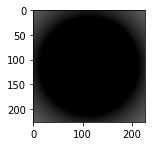

In [12]:
mask = net_input.clone()[:,:3,:imsize,:imsize] * 0
for i in range(imsize):
    for j in range(imsize):
        d = np.sqrt((i - imsize//2)**2 + (j - imsize//2)**2)
#         if d > 75:
        mask[:,:, i, j] = 1 - min(100./d, 1)
            
plot_image_grid([torch_to_np(mask)]);
use_mask = False

In [13]:
from utils.sr_utils import tv_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()


outs = [] 

def closure():
    
    global i, net_input
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std()/50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)[:, :, :imsize, :imsize]
    
#     out = out* (1-mask)
   
        
    cnn(vgg_preprocess_caffe(out))
    total_loss =  sum(matcher_content.losses.values()) * 5
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(vgg_preprocess_caffe(out), beta=2)
        
    
    if use_mask:
        total_loss += nn.functional.mse_loss(out * mask, mask * 0, size_average=False) * 1e1
    
    total_loss.backward()

    print ('Iteration %05d    Loss %.3f' % (i, total_loss.item()), '\r', end='')
    if PLOT and  i % 100==0:
        out_np = np.clip(torch_to_np(out), 0, 1)
        plot_image_grid([out_np], 3, 3, interpolation='lanczos');
        
        outs.append(out_np)
    i += 1
    
    return total_loss

Starting optimization with ADAM


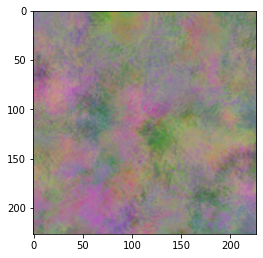

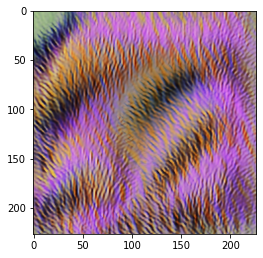

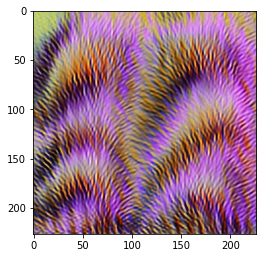

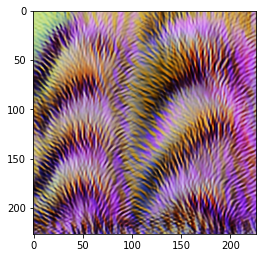

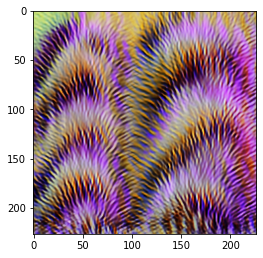

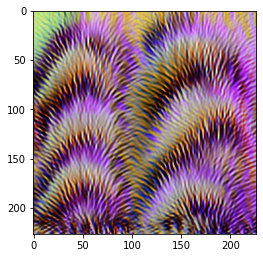

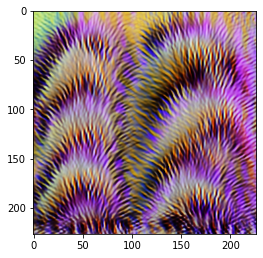

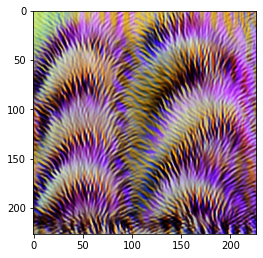

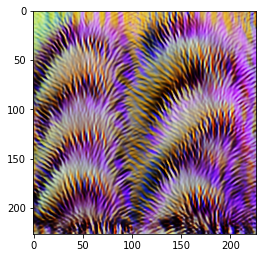

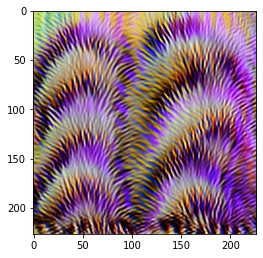

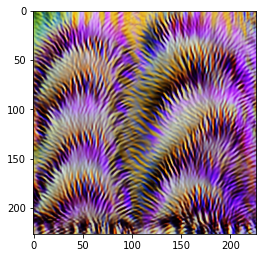

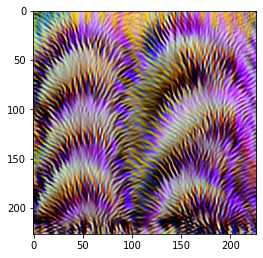

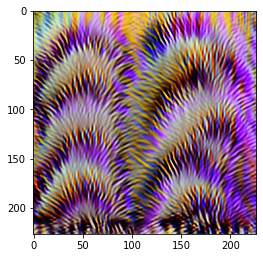

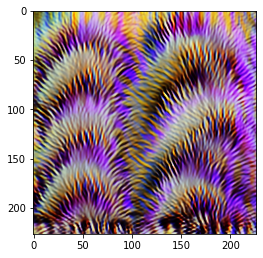

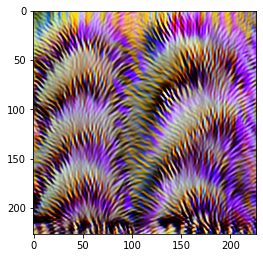

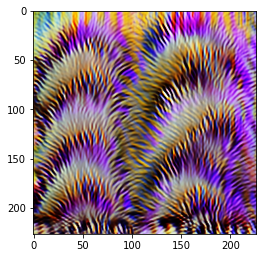

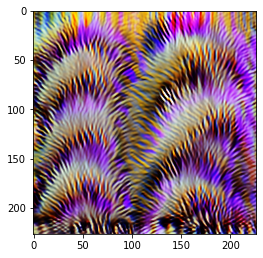

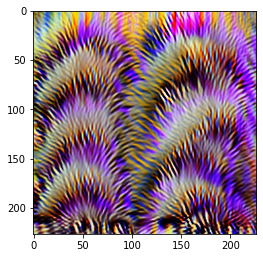

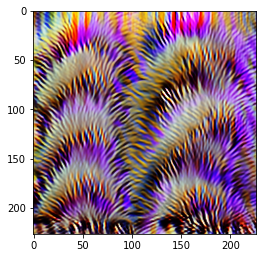

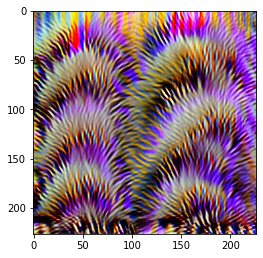

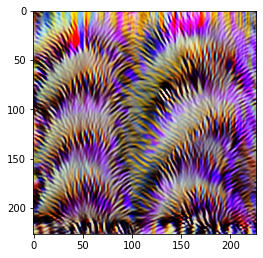

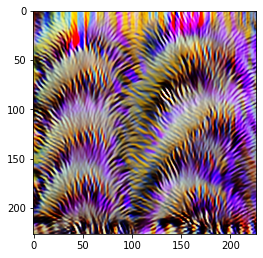

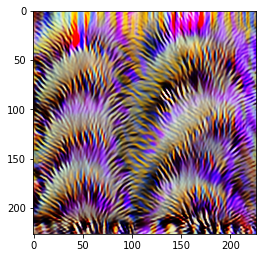

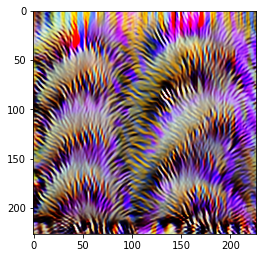

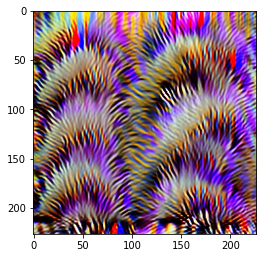

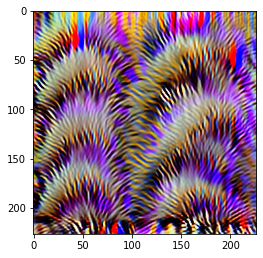

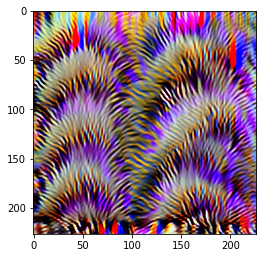

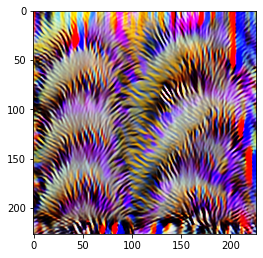

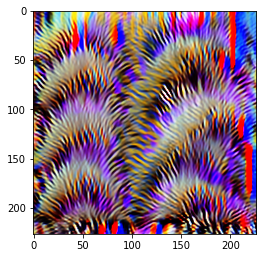

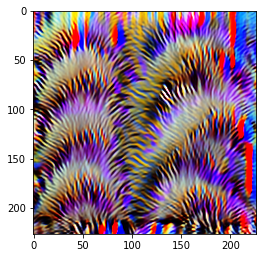

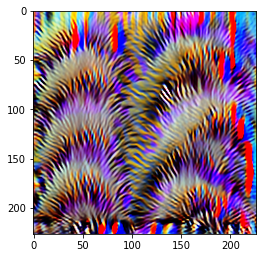

In [14]:
i=0

p = get_params(OPT_OVER, net, net_input)

optimize(OPTIMIZER, p, closure, LR, num_iter)

# Result

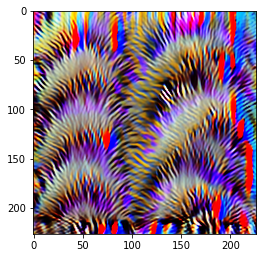

In [15]:
out = net(net_input)[:, :, :imsize, :imsize]
plot_image_grid([torch_to_np(out)], 3, 3);